In [1]:
%reload_ext autoreload
%autoreload 2
import sinter
import matplotlib.pyplot as plt
import os

from qecdec import RotatedSurfaceCode_Memory
from qecdec import BPDecoder
from qecdec.sinter_wrapper import SinterDecoderWrapper

In [2]:
def generate_sinter_tasks_and_custom_decoders():
    tasks: list[sinter.Task] = []
    custom_decoders: dict[str, sinter.Decoder] = {}
    for d in [5, 7, 9, 11]:
        for p in [0.004, 0.006, 0.008, 0.01, 0.012]:
            # Setup the experiment.
            expmt = RotatedSurfaceCode_Memory(
                d=d,
                rounds=d,
                basis='Z',
                data_qubit_error_rate=p,
                meas_error_rate=p,
                prep_error_rate=p,
                gate1_error_rate=p,
                gate2_error_rate=p,
            )

            # Setup a sinter.Task with MWPM decoder.
            tasks.append(sinter.Task(
                circuit=expmt.circuit,
                detector_error_model=expmt.dem,
                decoder='pymatching',
                json_metadata={'d': d, 'p': p, 'decoder': 'pymatching'},
            ))

            # Setup a sinter.Task with BP decoder.
            bp = BPDecoder(expmt.chkmat, expmt.prior, max_iter=50)
            custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
            custom_decoders[custom_decoder_id] = SinterDecoderWrapper(bp, expmt.obsmat)
            tasks.append(sinter.Task(
                circuit=expmt.circuit,
                detector_error_model=expmt.dem,
                decoder=custom_decoder_id,
                json_metadata={'d': d, 'p': p, 'decoder': 'bp'},
            ))
    return tasks, custom_decoders

tasks, custom_decoders = generate_sinter_tasks_and_custom_decoders()


In [3]:
sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...
40 tasks left:
  workers           decoder eta shots_left errors_left json_metadata                  
        1        pymatching   ?   10000000         100 d=5,p=0.004,decoder=pymatching 
        1  custom_decoder_0   ?   10000000         100 d=5,p=0.004,decoder=bp         
        1        pymatching   ?   10000000         100 d=5,p=0.006,decoder=pymatching 
        1  custom_decoder_1 <1m    9999727          80 d=5,p=0.006,decoder=bp         
        1        pymatching   ?   10000000         100 d=5,p=0.008,decoder=pymatching 
        1  custom_decoder_2   ?   10000000         100 d=5,p=0.008,decoder=bp         
        1        pymatching   ?   10000000         100 d=5,p=0.01,decoder=pymatching  
        0  custom_decoder_3 ?·∞   10000000         100 d=5,p=0.01,decoder=bp          
        0        pymatching ?·∞   10000000         100 d=5,p=0.012,decoder=pymatching 
        0  custom_decoder_4 ?·∞   10000000         100 d=5,p=0.012,decoder=bp         
      

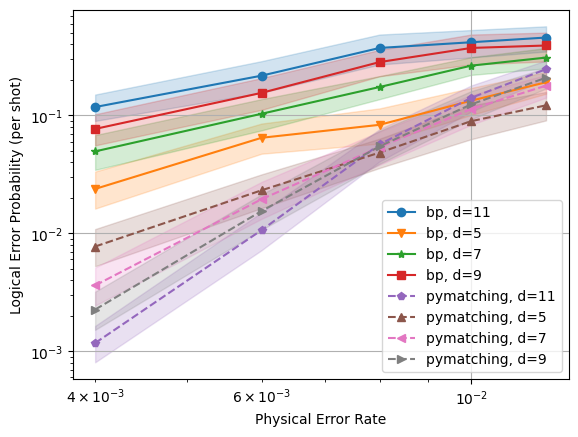

In [4]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"{stat.json_metadata['decoder']}, d={stat.json_metadata['d']}",
    x_func=lambda stat: stat.json_metadata['p'],
    plot_args_func=lambda index, group_key: {
        'linestyle': 'solid' if group_key[:2] == 'bp' else 'dashed',
    }
)
ax.loglog()
ax.grid()
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Physical Error Rate')
ax.legend()